# Oliver Baby Sleep Data

This notebook explores a data set of baby sleep, feeding, diaper changes, and other avaialbe variables as provided by the App "Baby Daybook" which my wife and I used as our primary tracker when our son was born. More detailed analysis focuses on sleep.

In [1]:
import numpy as np                    # The usual libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; #seaborn.set()
%matplotlib inline

import sqlite3 as sql                 # Need this since app data export is in .db format
import datetime as dt                 # To deal converting timeseries format
from datetime import date
import matplotlib.dates as mdates     # To deal with displaying proper timeseries format in plots

from IPython import display
import base64
#from base64 import b64decode
#import matplotlib as mpl
#from matplotlib.widgets import Slider

/var/folders/wq/5jk9z2rs2t1bxpft52w_sgkc0000gn/T/ipykernel_8171/4116843207.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## First Explore the SQL Database (using sqlite)

In [2]:
# Connect to the database and create cursor to execute SQL statements and fetch query results

db_conn = sql.connect("BabyDaybook_20240307.db")
db_cursor = db_conn.cursor()

In [3]:
# Let's see what tables exist in the database

sql_query_tables = """SELECT name FROM sqlite_master 
    WHERE type='table';"""

#tables=cursor.execute(sql_query1)
tables=db_cursor.execute(sql_query_tables).fetchall()

print("\nTables in databse:\n")
print(tables)
print(type(tables))
print(type(tables[0]))


Tables in databse:

[('babies',), ('da_types',), ('daily_actions',), ('groups',), ('growth',), ('moments',), ('daily_notes',), ('reminders',), ('teething',)]
<class 'list'>
<class 'tuple'>


In [4]:
# Now let's see what parameteres are stored in the different tables (choose index)

tableOfInterest =''.join(tables[0])              #converts tuple to string, index = table of interest based on output above
print("Table of Interest:",tableOfInterest)

sql_query_table_params ="SELECT * FROM "+ tableOfInterest;

data=db_cursor.execute(sql_query_table_params)

print("\nParameters in table:\n")
for column in data.description:
    print(column[0],end=',')

Table of Interest: babies

Parameters in table:

uid,svt,updated_millis,user_uid,name,gender,birthday,is_premature,expected_birthday,ui_color,da_types_config,photo_base64,convert_units,

In [5]:
# Afer going through the tables, daily_actions (index 2) has the data of interest, let's see what it looks like 

tableOfInterest =''.join(tables[2])  
print("Table of Interest:",tableOfInterest)

sql_query3 = "SELECT type, start_millis, end_millis, duration, pee, poo, volume, notes FROM daily_actions"
#sql_query4 = "SELECT start_millis, end_millis, duration FROM daily_actions WHERE type = 'sleeping' "

data=db_cursor.execute(sql_query3).fetchall() #fetchone()

print("\nFirst 4 entries:\n")

for i in range (0,4):
    print(data.pop(i))

Table of Interest: daily_actions

First 4 entries:

('sleeping', 1644556680000, 1644570600000, 13920000, 0, 0, 0.0, '')
('bottle', 1644570900000, 0, 0, 0, 0, 74.0, '')
('sleeping', 1644573600000, 1644582900000, 9300000, 0, 0, 0.0, '')
('pump', 1644583800000, 0, 0, 0, 0, 110.0, '15min')


## Use pandas to store data of interest  into dataframe

In [6]:
# Start with baby info data

tableOfInterest =''.join(tables[0])       # babies table from db          
sql_query_table_params ="SELECT * FROM "+ tableOfInterest;

BabyInfo=pd.read_sql(sql_query_table_params, db_conn)
print(BabyInfo.columns)

babyName=BabyInfo['name'][0]
babyDoB=BabyInfo['birthday'][0]
#print(type(babyDoB))                     # this helped me determine it was int64 format and needed conversiont format
print('Baby DoB, int64:',babyDoB)

babyDoB=pd.to_datetime(babyDoB,unit='ms')
print('Baby DoB, timestamp:',babyDoB)

Index(['uid', 'svt', 'updated_millis', 'user_uid', 'name', 'gender',
       'birthday', 'is_premature', 'expected_birthday', 'ui_color',
       'da_types_config', 'photo_base64', 'convert_units'],
      dtype='object')
Baby DoB, int64: 1643097600000
Baby DoB, timestamp: 2022-01-25 08:00:00


Good practice for another time: store the timestamp version of DOB back into the database

In [7]:
# This will display and save what photo is stored in the db

babyPic=BabyInfo['photo_base64'][0]
#print(babyPic)                                             # this helped me determine it was ASCI encoded and needed conversion

# display.Image(b64decode(babyPic))                         # Display image in-line, or alternatively:

#with open("babyPic.png", "wb") as fig_handle:              # Save it as a png file
#  fig_hanlde.write(base64.urlsafe_b64decode(babyPic))

### Closer look at data format, conversions as needed

In [8]:
# Let's explore the primary data of intersest, Sleep/Diaper/Feeding logs from daily_actions table

tableOfInterest =''.join(tables[2])                                   
sql_query_table_params ="SELECT * FROM "+ tableOfInterest;

BabyDailyData=pd.read_sql(sql_query_table_params, db_conn)
type_counts = BabyDailyData['type'].value_counts()

print('BabyDailyData size:', BabyDailyData.shape)
print('\nBabyDailyData Columns:\n', BabyDailyData.columns)
print('\nBabyDailyData Type values:\n',BabyDailyData['type'].unique())
print('\nEvent counts:\n')
print(type_counts)

BabyDailyData size: (9952, 24)

BabyDailyData Columns:
 Index(['uid', 'svt', 'updated_millis', 'user_uid', 'baby_uid', 'type',
       'start_millis', 'notes', 'group_uid', 'end_millis', 'pause_millis',
       'duration', 'left_duration', 'right_duration', 'in_progress', 'side',
       'pee', 'poo', 'hair_wash', 'temperature', 'volume', 'amount',
       'amount_unit', 'reaction'],
      dtype='object')

BabyDailyData Type values:
 ['sleeping' 'pump' 'bottle' 'diaper_change' 'breastfeeding' 'tummy_time'
 'bath' 'medicine' 'alvukaFFSWXJHCBIIPKDUBECBMGP3512' 'symptom'
 'mxmVKLAOWKFYCUKVVYDS028521473055' 'playtime' 'walking_outside' 'crying'
 'P4383824042888488153776645035805' 'vaccination' 'doctor_visit' 'other'
 'food' 'temperature']

Event counts:

type
sleeping                            2999
breastfeeding                       2692
diaper_change                       2655
bottle                               693
pump                                 408
medicine                         

In [9]:
# Wanted to understand what are the random alphanumeric string "types" above: they appear to be deleted entries

#filter_odd = BabyDailyData['type'].str.contains('P4383824042888488153776645035805')
#OddData=BabyDailyData[filter_odd]
#OddData['datetime']=pd.to_datetime(OddData['start_millis'],unit='ms')-pd.Timedelta(8,'h') 
#OddData.tail()

In [10]:
# Create a new parameter in datetime format for easier understanding (instead of db use of milliseconds), & convert from UTC time

BabyDailyData['datetime']=pd.to_datetime(BabyDailyData['start_millis'],unit='ms')-pd.Timedelta(8,'h') 

# Clean up some of the columns not of interest for my analysis
BabyDailyData.drop(columns=['uid', 'svt','updated_millis','user_uid','baby_uid','group_uid'],inplace=True)
BabyDailyData.drop(columns=['temperature','in_progress','hair_wash', 'reaction','amount','amount_unit'],inplace=True)

BabyDailyData.head()

,type,start_millis,notes,end_millis,pause_millis,duration,left_duration,right_duration,side,pee,poo,volume,datetime
0,sleeping,1644556680000,,1644570600000,0,13920000,0,0,,0,0,0.0,2022-02-10 21:18:00
1,pump,1644566940000,,0,0,0,0,0,both,0,0,104.0,2022-02-11 00:09:00
2,bottle,1644570900000,,0,0,0,0,0,,0,0,74.0,2022-02-11 01:15:00
3,diaper_change,1644573300000,,0,0,0,0,0,,1,1,0.0,2022-02-11 01:55:00
4,sleeping,1644573600000,,1644582900000,0,9300000,0,0,,0,0,0.0,2022-02-11 02:00:00


## Closer look at Sleep Data

In [11]:
# Extract only the sleep logs

filter_sleep = BabyDailyData['type'].str.contains('sleeping')
SleepData=BabyDailyData[filter_sleep][['datetime','duration']]

print('Full data index:',BabyDailyData.index)
print('Sleep data index:',SleepData.index)

# Reorder and clean up indices (the indices inherited are from the original larger database -with more types)

SleepData=SleepData.sort_values(by=['datetime']);
SleepData.index=np.arange(len(SleepData['datetime']))

print('Reindexed Sleep data index:',SleepData.index)

#Sleepdata=Sleepdata.sort_values(by=['datetime_tz']);
#Sleepdata.index=np.arange(len(Sleepdata['datetime_tz']))

SleepData.tail()

Full data index: RangeIndex(start=0, stop=9952, step=1)
Sleep data index: Index([   0,    4,   10,   13,   16,   19,   23,   28,   31,   34,
       ...
       9936, 9937, 9938, 9939, 9944, 9947, 9948, 9949, 9950, 9951],
      dtype='int64', length=2999)
Reindexed Sleep data index: Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
       ...
       2989, 2990, 2991, 2992, 2993, 2994, 2995, 2996, 2997, 2998],
      dtype='int64', length=2999)


,datetime,duration
2994,2024-03-05 13:00:00.000,7200000
2995,2024-03-05 21:04:23.975,33966710
2996,2024-03-06 13:01:00.000,9540000
2997,2024-03-06 19:30:00.000,10800000
2998,2024-03-06 22:55:00.000,0


In [279]:
# Use datetime library to specify time period of interest in the appropriate format, and filter data correspondingly

startDate=dt.date(2022,1,29)              # For full duration: 1/29/2022
endDate=dt.date(2024,3,5)

#startDate=endDate-pd.Timedelta(3,'m')
#endDate=date.today()

numDays=pd.Timedelta(endDate-startDate).days+1 #inclusive of both start and end date

print('Start date:', startDate)
print('End date:',endDate)
print('\nTime span of interest, days:',numDays)

daylightDatetime=dt.datetime(2022,3,13,2)

timePeriodFilter_start=SleepData['datetime']>=pd.Timestamp(startDate)
timePeriodFilter_end=SleepData['datetime']>=pd.Timestamp(endDate+pd.Timedelta(1,'d')) #one day after because many events on last day

startIndex=np.where(timePeriodFilter_start)[0][0]; # First element where date >= start date
endIndex=np.where(timePeriodFilter_end)[0][0]-1;  # First element where date >= end date, substract one for last event of prior day

Start date: 2022-01-29
End date: 2024-03-05

Time span of interest, days: 767


In [278]:
SleepData.iloc[endIndex]

datetime    2024-03-05 21:04:23.975000
duration                      33966710
Name: 2995, dtype: object

## Create daily sleep vectors and correct for timezone differences (DST, travel still pending)

In [20]:
# Brake up continuous timestamped data into descrete daily vectors representing daily activity occurances

res=5; # time Vector resolution = 5min
dailySleepP=np.zeros((numDays+1,int(24*60/res))) #initialize numDays x vectors of length int(24*60/res) - Number of 5min segments in day

# Daylight saving time change dates (https://www.timetemperature.com/tzus/daylight_saving_time.shtml)
DSTdatetime_2022start=dt.datetime(2022,3,13,2)
DSTdatetime_2022end=dt.datetime(2022,11,6,2)
DSTdatetime_2023start=dt.datetime(2023,3,12,2)
DSTdatetime_2023end=dt.datetime(2023,11,5,2)

#attempt to correct daylight savings (did not work):
#timePeriodFilter=Sleepdata['datetime_tz']>=pd.Timestamp(endDate+pd.Timedelta(1,'d')).replace(tzinfo=timezone.utc)

vectorIndexMax=dailySleepP.shape[1]
vectorDate=startDate;
uniqueDateCounter=0;

# Loop to vectorize day from list of timestamped events
for event_index in range(startIndex-1,endIndex+1): # Purposely start on the event prior to first, +1 on endIndex to include last one

    eventDatetime=SleepData['datetime'][event_index]
    
    # This block is to correct for daylight savings... it's incomplete, and there's gotta be a better way
    isDST=(eventDatetime>DSTdatetime_2022start and eventDatetime<=DSTdatetime_2022end) or \
        (eventDatetime>DSTdatetime_2023start and eventDatetime<=DSTdatetime_2023end)
    if isDST:
        event_date=(SleepData['datetime'][event_index]+pd.Timedelta(1,'h')).date();
        event_time_of_day=SleepData['datetime'][event_index]+pd.Timedelta(1,'h')-dt.datetime.combine(event_date, dt.time(0,0));
        #print('debug:', event_date, 'daylight saving time')
    else:
        event_date=SleepData['datetime'][event_index].date();
        event_time_of_day=SleepData['datetime'][event_index]-dt.datetime.combine(event_date, dt.time(0,0));
    
    event_time_minutes=int(event_time_of_day.total_seconds()/60);
    vectorIndex=int(event_time_minutes/res);
    duration=int(SleepData['duration'][event_index]/1000/60/res);
    
    # Build the next vector if already accounted for all events in same date
    if event_date>vectorDate: 
        uniqueDateCounter+=(event_date-vectorDate).days;
        vectorDate=vectorDate+pd.Timedelta(1,'d');

    # To account for overnight events (that span two different dates)
    if vectorIndex+duration>=vectorIndexMax:
        #print('Debug:', SleepData.iloc[event_index].datetime, 'duration:',duration)
        firsthalf=vectorIndexMax-vectorIndex;
        secondhalf=duration-firsthalf;
        
        # For first event, reach into prior date entry to overnight portion
        if event_index==startIndex-1 and vectorDate>dt.date(2022,1,25): 
            dailySleepP[uniqueDateCounter,0:secondhalf]=np.ones(secondhalf) # populate overnight portion from prior date
        else:
            #print('\n debug, uniqueDateCounter:',uniqueDateCounter,'numDays:',numDays)
            #print('max vector index:',vectorIndexMax,'vector index:',vectorIndex, 'firsthalf_bins',firsthalf)
            dailySleepP[uniqueDateCounter,vectorIndex:]=np.ones(firsthalf);
            if uniqueDateCounter<numDays:
                dailySleepP[uniqueDateCounter+1,0:secondhalf]=np.ones(secondhalf)
    else:
        #if uniqueDateCounter<=numDays:
        if uniqueDateCounter<=numDays and event_index>startIndex-1:
            dailySleepP[uniqueDateCounter,vectorIndex:vectorIndex+duration]=np.ones(duration)
            #if i>=endIndex0:    #debug
            #    print(i, uniqueDateCounter, date, daytime, duration)
        #print('debug, event date',event_date,'vector counter',uniqueDateCounter,'vector date',vectorDate)
            
#print('Number of dayly vectors:',len(dailySleepP))

### Visualize what these average sleep patterns look like at different periods of interest

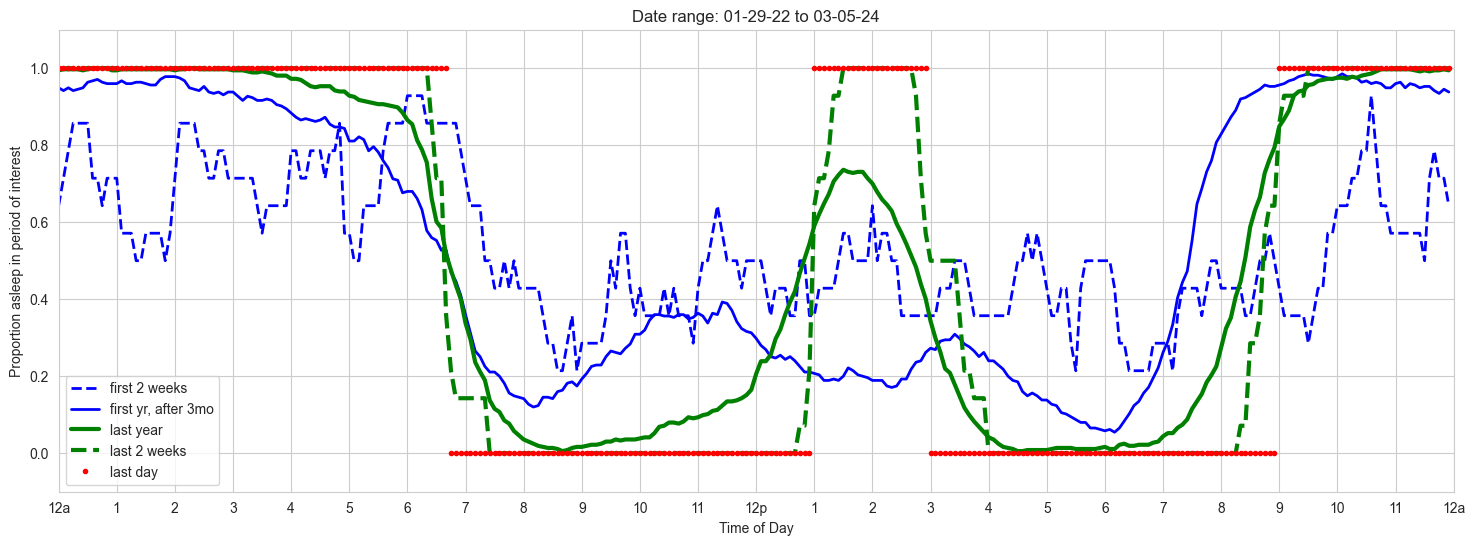

In [17]:
# Plot average daily vectors to look for patterns

fig, ax = plt.subplots(figsize=(18,6))

sns.set_style("whitegrid")
sns.axes_style("whitegrid")

#plotDate=datetime.date(2022,3,14)
#dayNum=pd.Timedelta(plotDate-startDate).days

curve1, = ax.plot(dailySleepP[0:14,].mean(axis=0),'b--', label='first 2 weeks', linewidth=2)
curve2, = ax.plot(dailySleepP[90:365,].mean(axis=0),'b', label='first yr, after 3mo', linewidth=2)
curve3, = ax.plot(dailySleepP[-365:-1,].mean(axis=0),'g', label='last year', linewidth=3)
curve4, = ax.plot(dailySleepP[-15:-1,].mean(axis=0),'g--',label='last 2 weeks', linewidth=3)
curve5, = ax.plot(dailySleepP[-2,],'r.',label='last day')
     
#biweekly=np.arange(0,numDays-14,int(numDays/14)); # Need an error catch for shorter analysis ranges
#i=biweekly[12] 
#curve3, = ax.plot(dailySleepP[i:i+14,].mean(axis=0),'g', label='last 2 weeks', linewidth=3)

ax.legend(handles=[curve1, curve2, curve3, curve4,curve5])

plt.xlabel('Time of Day')
plt.ylabel('Proportion asleep in period of interest')

timeticks=np.arange(0, vectorIndexMax+1, step=int(vectorIndexMax/24));
timelabels=['12a','1','2','3','4','5','6','7','8','9','10','11','12p','1','2','3','4','5','6','7','8','9','10','11','12a']
plt.xticks(timeticks,timelabels);  # Set label locations.
plt.axis([0, vectorIndexMax,-.1,1.1]);

#plotDate=startDate+pd.Timedelta(dayNum,'d')
plt.title('Date range: '+ startDate.strftime("%m-%d-%y")+ ' to ' + endDate.strftime("%m-%d-%y"));

Fig_name= 'Oliver_SleepDailyProb_'+ startDate.strftime("%m-%d-%y")+ '_to_' + endDate.strftime("%m-%d-%y");
fig.savefig(Fig_name)

Observations: 
- Those first few weeks are insane... There is no time of day with 100% of samples asleep! (but 6am and 10:30pm reach 90%)
- Can see "two nap" schedule in the afternoon in the first year (around 10am and 3pm)
- Much more stable "one nap" schedule in the last year (~second year)
  - typically wake after 6:30am, ~2hr nap at ~12:45pm, typically going to sleep 8:30pm
 
Note: several weeks in timezones +3h also contribute to the above averages, haven't decided how to treat those

### Visualize how these daily sleep patterns change over time

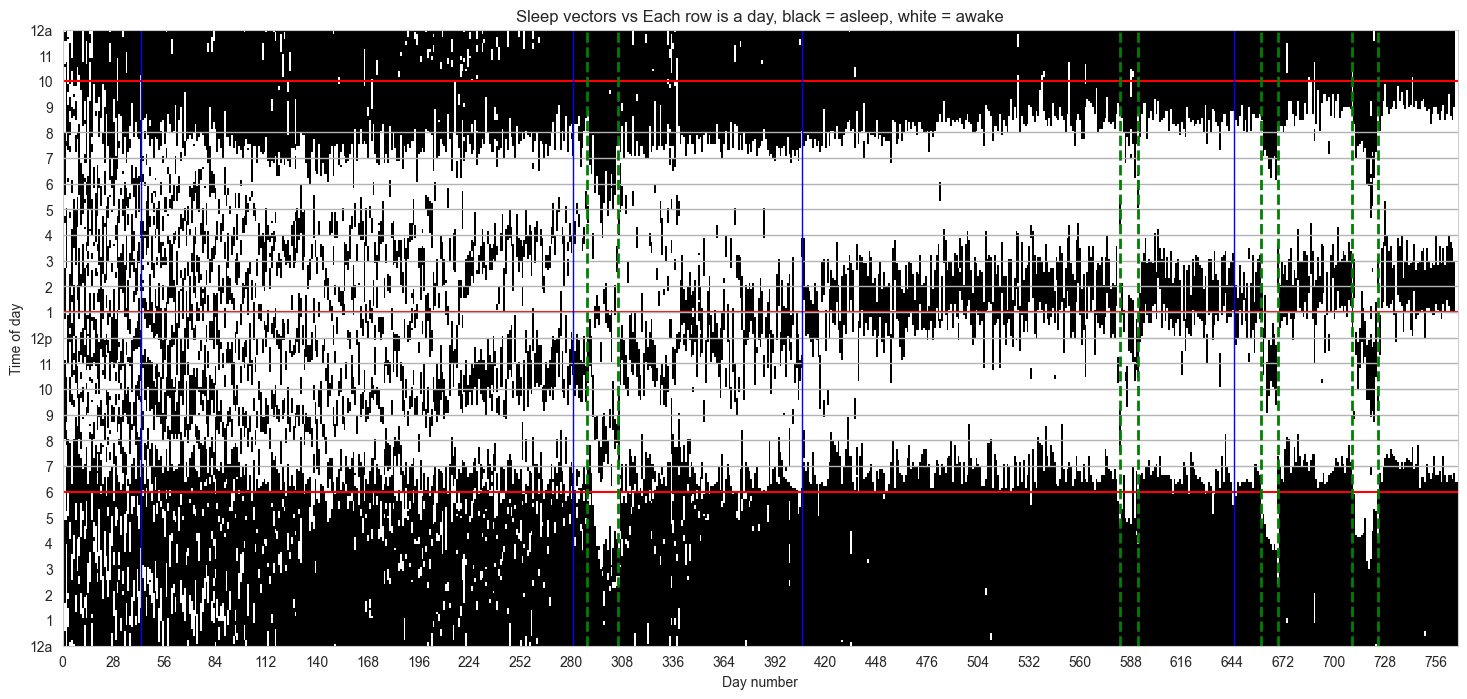

In [276]:
# Create chart of all the daily activity vectors to look for patterns by eye

# Some relevant markers for the y axis
babyAwake=6;    # 6 am - After this time he's generally not asleep (Psleep < 90%)
babyNap=1;      # 1 pm - Ideal nap time
babyAsleep=10;  # 9 pm - After this time he's generally asleep (Psleep > 90%)

dailyDayInd=int(vectorIndexMax/24*babyAwake); 
dailyNightInd=int(vectorIndexMax/24*(babyAsleep+12));
dailyNapInd=int(vectorIndexMax/24*(babyNap+12));

fig = plt.figure(figsize=(18,8))

plt.pcolor(dailySleepP.transpose(),cmap='gray_r')

plt.axhline(y = dailyDayInd, color = 'r', label = '6 am')
plt.axhline(y = dailyNightInd, color = 'r', label = '9 pm')
plt.axhline(y = dailyNapInd, color = 'r', label = '1 pm')

for h in range(0,14):
    lineind=int(vectorIndexMax/24*(7+h)); 
    plt.axhline(y = lineind, color='0.7', linewidth=1);

ind_DST_2022start=(DSTdatetime_2022start.date()-startDate).days
ind_DST_2022end=(DSTdatetime_2022end.date()-startDate).days
ind_DST_2023start=(DSTdatetime_2023start.date()-startDate).days
ind_DST_2023end=(DSTdatetime_2023end.date()-startDate).days

# Add vertical lines that correspond to daylight saving changes
plt.axvline(x = ind_DST_2022start, color='b', linewidth=1,label='DST change');
plt.axvline(x = ind_DST_2022end, color='b', linewidth=1);
plt.axvline(x = ind_DST_2023start, color='b', linewidth=1);
plt.axvline(x = ind_DST_2023end, color='b', linewidth=1);

# Add vertical lines that correspond to timezone changes from travel (see two blocks down)
for i in tzChange.index:
    ind_tzChange= (tzChange['datetime'][i].date()-startDate).days
    plt.axvline(x = ind_tzChange, color='g', linestyle='dashed',linewidth=2);

# plt.colorbar(); # Not useful here since it's binary data 
    
plt.xticks(np.arange(0,numDays,28))
plt.yticks(timeticks,timelabels)


plt.xlabel('Day number')
plt.ylabel('Time of day')
plt.title('Daily sleep vectors vs days, black = asleep, white = awake');

#datelabels=pd.date_range(startDate, endDate+pd.Timedelta(1,'d')).strftime("%m-%d");

#datelabels=pd.date_range(startDate, endDate).strftime("%m-%d"); #not used

#plt.yticks(np.arange(0, numDays+1),datelabels);


plt.title('Sleep vectors vs Each row is a day, black = asleep, white = awake');

#Fig_name= 'Oliver_SleepMap_'+ startDate.strftime("%m-%d-%y")+ '_to_' + endDate.strftime("%m-%d-%y");
#fig.savefig(Fig_name)

In [59]:
# Take note of dates where visual anomalies are observed

print(startDate + dt.timedelta(days=300))
print(startDate + dt.timedelta(days=588))
print(startDate + dt.timedelta(days=662))
print(startDate + dt.timedelta(days=714))

2022-11-25
2023-09-09
2023-11-22
2024-01-13


In [84]:
# Dates of timezone change (travel), these are used back in the chart two blocks above

# Travel dates to FL, Costa Rica, FL, Colombia
tzChange_dt = pd.Series(data=[dt.datetime(2022,11,14,16),dt.datetime(2022,12,1,9),dt.datetime(2023,9,3,10),dt.datetime(2023,9,13,18),\
                         dt.datetime(2023,11,20,12),dt.datetime(2023,11,29,12),dt.datetime(2024,1,9,9),dt.datetime(2024,1,23,17)])

tzChange_delta = pd.Series(data=[3,-3,3,-3,3,-3,3,-3])

tzChange=pd.DataFrame({'datetime':tzChange_dt,'delta': tzChange_delta})
    ind_tzChange= (tzChange['datetime'][i].date()-startDate).days

## Start Data Analysis, aggregating and other signal extraction

In [85]:
# Create a simplified data frame with sleep data aggregaged by date

dx=SleepData.groupby(by=SleepData['datetime'].dt.date)

SleepDaily=dx['datetime'].count().to_frame()
SleepDaily.columns=['count']
SleepDaily['longest sleep']=dx['duration'].max()/1000/60/60

skipDates1=(startDate-SleepDaily.index[0]).days
skipDates2=(SleepDaily.index[-1]-endDate).days

SleepDaily = SleepDaily.iloc[skipDates1-1:-skipDates2, :] # Remove the rows that were not of interest for analysis
SleepDaily['total sleep']=dailySleepP[:-1,:].sum(axis=1)*res/60 # Sum all the bins with sleep=1

print(SleepDaily)

            count  longest sleep  total sleep
datetime                                     
2022-01-29      6       3.333333    10.916667
2022-01-30      7       3.266667    12.000000
2022-01-31      8       2.750000    10.666667
2022-02-01      8       3.000000    10.416667
2022-02-02     10       4.033333    13.666667
...           ...            ...          ...
2024-03-01      2       9.966667    11.750000
2024-03-02      2       9.233333    11.916667
2024-03-03      2       9.833333    12.750000
2024-03-04      2      10.250000    12.500000
2024-03-05      2       9.435197    11.750000

[767 rows x 3 columns]


### Various operations on the daily sleep "vectors" to measure various transitions and durations vs time (daily)

In [281]:
LongestWake=[]
LongestWakeHour=[]
LongestSleepHour=[]
AverageDayNap=[]
AverageDayWake=[]
DayNapCount=[]
NightWakeCount=[] 

# Various loops to detect changes in the state of the daily sleep vector, under various conditions
for i in range(0,len(SleepDaily)):  

    # Look only at state transitions after some typical waking time (dailyDayInd)
    testS=format(dailySleepP[i,dailyDayInd:-1].astype('int8')) #convert to string of integers (to use strip/split func)
    testS=testS[1:-1].replace(" ","").replace("\n","") #remove all formating in string    
    wakes=testS.strip('1').split('1')
    wakes=[ele for ele in wakes if ele != '']
    maxW=max(wakes)               #separate out all the wake periods (sleepP=0) and find max
    LongestWake.append(len(maxW)*res/60)
    LongestWakeHour.append((testS.find(maxW)+dailyDayInd)*res/60)

    dailyBedtimeMin=int(vectorIndexMax/24*(12+4))  # 4pm
    dailyBedtimeMax=int(vectorIndexMax/24*(12+11)) # 11pm

    # Look only at state transitions within some some high confidence bedtime window (BedtimeMin to BedtimeMax)
    testS=format(dailySleepP[i,dailyBedtimeMin:dailyBedtimeMax].astype('int8')) 
    testS=testS[1:-1].replace(" ","").replace("\n","") 
    sleeps=testS.strip('0').split('0')
    sleeps=[ele for ele in sleeps if ele != '']
    maxS=max(sleeps)              #separate out all the sleep periods (sleepP=1) and find max
    LongestSleepHour.append((testS.find(maxS)+dailyBedtimeMin)*res/60)

    # Look only at state transitions after some typical waking time (dailyDayInd) but before typical bed time (dailyNightIn)
        # This piece below only works when there are multiple naps within the time period, had to increase dailyNight to 10pm
    testS=format(dailySleepP[i,dailyDayInd:dailyNightInd].astype('int8')) #convert to string of integers (to use strip/split func)
    testS=testS[1:-1].replace(" ","").replace("\n","") #remove all formating in string

    # print('debug:',i) # Showed that it failed for i=522, when dailyNightIn was set to 9pm
    # print(SleepDaily.iloc[522])  # Showed that it failed around 2023-07-05

    if testS[0]=='0':     # If awake at dailyDayInd, strip all awake (0) bins from the left i.e. find the next asleep period   
        testS=testS.lstrip('0')
    if testS[0]=='1':     # If asleep at dailyDayInd, strip all asleep (1) bins from the left i.e. find the next wake period
        testS=testS.lstrip('1')
    if testS[-1]=='0':    # If awake at dailyNightInd, strip all awake (0) bins from the right i.e. find the prior asleep period
        testS=testS.rstrip('0')
    if testS[-1]=='1':    # If asleep at dailyNightInd, strip all asleep (1) bins from the right i.e. find the prior wake period
        testS=testS.rstrip('1')
        
    #print('fourth:',testS) #to debug steps above
    dayNaps=testS.split('0');
    dayNaps = [ele for ele in dayNaps if ele != ''] # remove all the empty elements
    dayNapLengths = [len(ele) for ele in dayNaps]  
    dayWakes=testS.split('1');
    dayWakes = [ele for ele in dayWakes if ele != ''] # remove all the empty elements
    dayWakeLengths = [len(ele) for ele in dayWakes]
    dayWakeisnightWake=0;
    if dayWakeLengths[0]<=6:
        del dayWakeLengths[0]
        del dayNapLengths[0]
        dayWakeisnightWake=1;
    
    AverageDayNap.append(np.mean(dayNapLengths)*res/60) 
    AverageDayWake.append(np.mean(dayWakeLengths)*res/60)
    DayNapCount.append(len(dayNaps))

    # Look only at state transitions after bed time (dailyNightIn) and before typical waking time (dailyDayInd) the next day
    testS=format(dailySleepP[i,dailyNightInd:-1].astype('int8'))
    testS+=format(dailySleepP[i+1,0:dailyDayInd].astype('int8'))
    testS=testS.replace(" ","").replace("\n","").replace("]","").replace("[","")  
    nightWakes=testS.split('1')
    nightWakes = [ele for ele in nightWakes if ele != '']
    NightWakeCount.append(len(nightWakes)+dayWakeisnightWake)

SleepDaily['night wakes']=NightWakeCount
SleepDaily['longest wake']=LongestWake
SleepDaily['longest wake hour']=LongestWakeHour
SleepDaily['longest sleep hour']=LongestSleepHour
SleepDaily['average day nap']=AverageDayNap
SleepDaily['average day wake']=AverageDayWake
SleepDaily['day naps']=DayNapCount

#print('Avg wake window, last two weeks:',SleepDaily['average day wake'][-14:-1].mean())
print('Avg bedtime, last two weeks:',SleepDaily['longest sleep hour'][-14:-1].mean()-12,' pm')

SleepDaily.tail()

Avg bedtime, last two weeks: 8.782051282051277  pm


/Users/eperalta/miniforge3/envs/general-env/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/eperalta/miniforge3/envs/general-env/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


,count,longest sleep,total sleep,night wakes,longest wake,longest wake hour,longest sleep hour,average day nap,average day wake,day naps,total sleep filtered,longest sleep filtered,longest sleep hour filtered,longest wake filtered,average day wake filtered,average day nap filtered,day naps filtered,night wakes filtered,longest wake hour filtered,total sleep moving_avg
datetime,,,,,,,,,,,,,,,,,,,,
2024-03-01,2,9.966667,11.750000,0,7.083333,6.416667,20.750000,2.083333,6.125000,1,12.166667,9.937779,20.833333,6.440476,5.916667,NaN,1.0,0.0,6.678571,12.130952
2024-03-02,2,9.233333,11.916667,0,6.583333,6.666667,21.500000,2.750000,6.041667,1,12.166667,9.765728,20.857143,6.428571,5.916667,NaN,1.0,0.0,6.726190,12.071429
2024-03-03,2,9.833333,12.750000,0,6.333333,6.666667,20.666667,2.750000,5.625000,1,12.059524,9.736169,20.845238,6.476190,5.970238,NaN,1.0,0.0,6.630952,12.226190
2024-03-04,2,10.250000,12.500000,0,6.500000,6.500000,20.500000,2.500000,5.750000,1,12.023810,9.655561,20.916667,6.464286,5.988095,NaN,1.0,0.0,6.642857,12.166667
2024-03-05,2,9.435197,11.750000,0,6.250000,6.750000,21.000000,2.000000,6.125000,1,12.023810,9.579637,20.952381,6.345238,5.988095,NaN,1.0,0.0,6.690476,12.166667


In [258]:
# Testing smoothing functions

from matplotlib.dates import DateFormatter
from scipy.ndimage import uniform_filter1d
#from pandas.tseries.offsets import DateOffset  # did not end up using it

filter_window=7;
filter_label=str(filter_window)+" day avareage"

#SleepDaily['total sleep moving_avg'] = SleepDaily['total sleep'].rolling(window=filter_window).mean()         # Standard form, but has lag  
SleepDaily['total sleep filtered']=uniform_filter1d(SleepDaily['total sleep'], filter_window,mode='nearest')   # Same as above, without lag

#help(uniform_filter1d)

Note: try single exponential smooth

In [285]:
print(SleepDaily.index[0])
print(babyDoB.date()+DateOffset(months=3))
print(babyDoB.date()+dt.timedelta(days=90))
#print(SleepDaily.shape[0])
SleepDaily.head()
#help(dt.timedelta)

#datelabels=pd.date_range(startDate, endDate).strftime("%y-%m-%d");
#datelabels=datelabels[::30]

2022-01-29
2022-04-25 00:00:00
2022-04-25


,count,longest sleep,total sleep,night wakes,longest wake,longest wake hour,longest sleep hour,average day nap,average day wake,day naps,total sleep filtered,longest sleep filtered,longest sleep hour filtered,longest wake filtered,average day wake filtered,average day nap filtered,day naps filtered,night wakes filtered,longest wake hour filtered,total sleep moving_avg
datetime,,,,,,,,,,,,,,,,,,,,
2022-01-29,6,3.333333,10.916667,2,5.750000,7.333333,16.000000,2.083333,2.777778,2,10.964286,3.192857,17.273810,5.000000,2.364286,1.706349,2.428571,2.714286,10.392857,NaN
2022-01-30,7,3.266667,12.000000,4,2.583333,20.000000,17.583333,1.125000,1.388889,2,11.357143,3.292857,18.119048,4.511905,2.128175,1.510771,3.142857,2.714286,11.761905,NaN
2022-01-31,8,2.750000,10.666667,4,4.250000,10.500000,20.000000,1.208333,1.633333,4,11.440476,3.219048,18.357143,4.130952,1.939683,1.370295,3.571429,2.857143,11.619048,NaN
2022-02-01,8,3.000000,10.416667,3,5.166667,12.916667,19.333333,1.277778,2.416667,3,11.904762,3.278571,18.357143,3.773810,1.700595,1.173016,4.285714,2.857143,13.059524,NaN
2022-02-02,10,4.033333,13.666667,2,2.333333,16.916667,21.916667,0.714286,1.125000,7,12.511905,3.533333,19.190476,3.345238,1.518056,1.068849,4.571429,2.714286,13.738095,NaN


## Trend plots

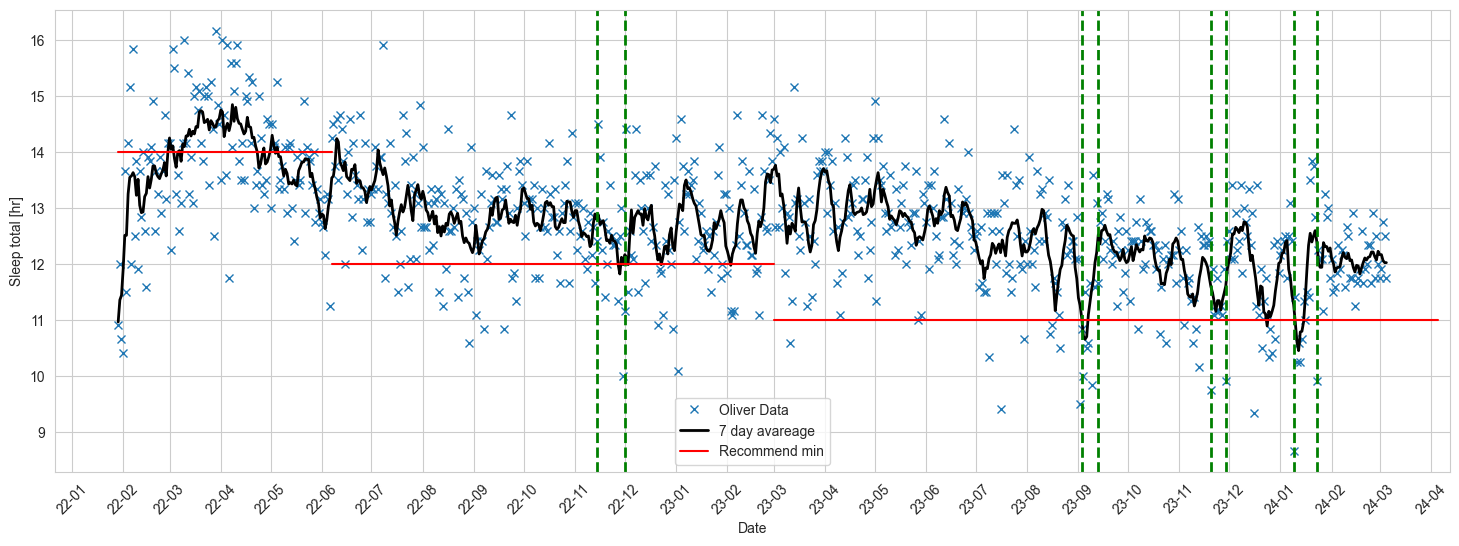

In [259]:
# Plot Total amount of sleep

fig, ax = plt.subplots(figsize=(18,6))
#fig = plt.figure(figsize=(18,8))

SleepDaily['total sleep filtered']=uniform_filter1d(SleepDaily['total sleep'], filter_window, mode='nearest')    

curve1, = ax.plot(SleepDaily['total sleep'],'x',markersize=6,label='Oliver Data');
#curve1a, = plt.plot(SleepDaily['total sleep'],'o--',markersize=8,label='Oliver Data');
curve2, = ax.plot(SleepDaily['total sleep filtered'],color='k',linewidth=2,label=filter_label);


for i in tzChange.index:
    ax.axvline(x = tzChange['datetime'][i].date(), color='g', linestyle='dashed',linewidth=2);

# Reference guidelines
date4mo=babyDoB.date()+dt.timedelta(days=4*30+2)
date12mo=babyDoB.date()+dt.timedelta(days=365)
date2yr=babyDoB.date()+dt.timedelta(days=365*2)

ind4mo=np.where(SleepDaily.index==date4mo)[0][0]
ind12mo=np.where(SleepDaily.index==date12mo)[0][0]
ind2yr=np.where(SleepDaily.index==date2yr)[0][0]
indbuffer=0.045
indmax=SleepDaily.shape[0]+2*indbuffer

curve3 = ax.axhline(y=14, xmin = 0+indbuffer , xmax = ind4mo/indmax+indbuffer,color='r',label='Recommend min') 
curve4 = ax.axhline(y=12, xmin = ind4mo/indmax+indbuffer , xmax = ind12mo/indmax+indbuffer,color='r') 
curve5 = ax.axhline(y=11, xmin = ind12mo/indmax+indbuffer , xmax = ind2yr/indmax+indbuffer,color='r') 

ax.set(xlabel='Date',ylabel='Sleep total [hr]');
ax.legend(loc='lower center')
plt.xticks(rotation = 45);

# Define the date format
date_form = DateFormatter("%y-%m")
ax.xaxis.set_major_formatter(date_form)
#help(mdates)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))

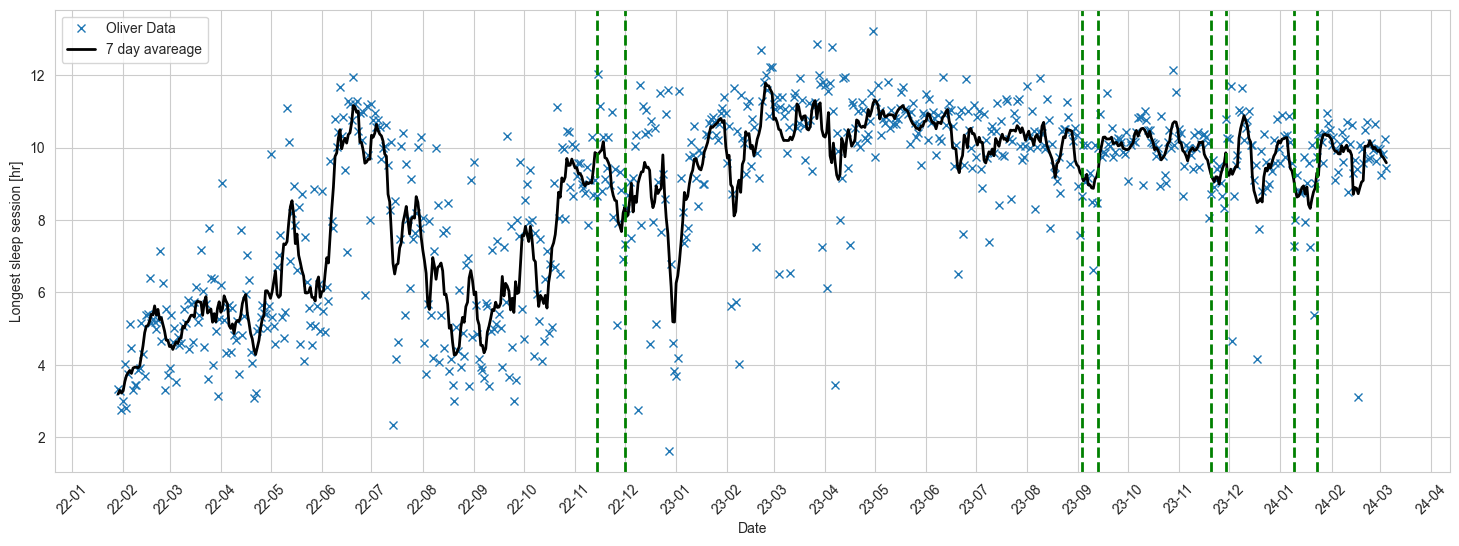

In [267]:
# Plot Longest Sleep Strech duration

fig, ax = plt.subplots(figsize=(18,6))

SleepDaily['longest sleep filtered']=uniform_filter1d(SleepDaily['longest sleep'], filter_window, mode='nearest')  

curve1, = ax.plot(SleepDaily['longest sleep'],'x',markersize=6, label='Oliver Data')
curve2, = ax.plot(SleepDaily['longest sleep filtered'],color='k',linewidth=2,label=filter_label)

ax.set(ylabel='Longest sleep session [hr]');
ax.legend(loc='upper left')

for i in tzChange.index:
    ax.axvline(x = tzChange['datetime'][i].date(), color='g', linestyle='dashed',linewidth=2);

ax.set(xlabel='Date');
plt.xticks(rotation = 45);

ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))

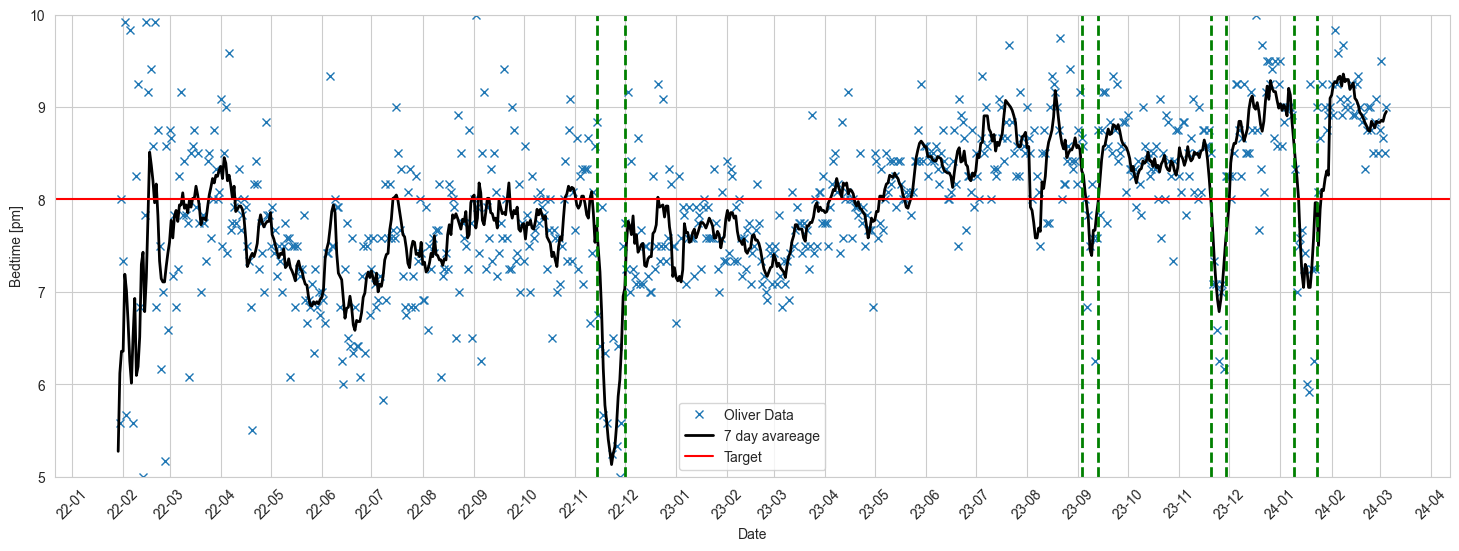

In [268]:
# Plot Bedtime

fig, ax = plt.subplots(figsize=(18,6))

SleepDaily['longest sleep hour filtered']=uniform_filter1d(SleepDaily['longest sleep hour'], filter_window, mode='nearest') 

curve1, = ax.plot(SleepDaily['longest sleep hour']-12, 'x',markersize=6, label='Oliver Data')
curve2, = ax.plot(SleepDaily['longest sleep hour filtered']-12,color='k',linewidth=2,label=filter_label)
curve3 = ax.axhline(y=20-12, xmin = 0, xmax = 1,color='r',label='Target') #c="red",linewidth=1)

ax.set(ylabel='Bedtime [pm]',ylim=[5,10]);
ax.legend(loc='lower center')

for i in tzChange.index:
    ax.axvline(x = tzChange['datetime'][i].date(), color='g', linestyle='dashed',linewidth=2);
    # Would be good to add logic that adds the tz diff in these regions to show local bedtime

ax.set(xlabel='Date');
plt.xticks(rotation = 45);

ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))

Would be interesting to better undertand/account for timezone changes (change to local time? something else?)

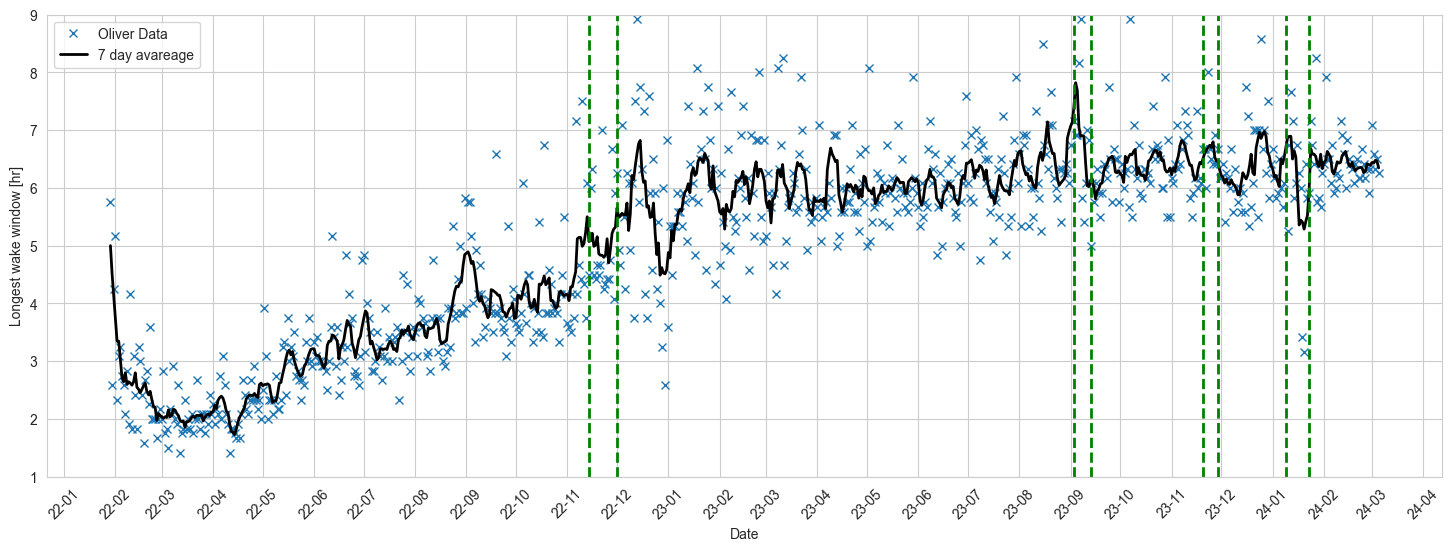

In [269]:
# Plot Longest Wake  Window
fig, ax = plt.subplots(figsize=(18,6))

SleepDaily['longest wake filtered']=uniform_filter1d(SleepDaily['longest wake'], filter_window, mode='nearest') 

curve1, = ax.plot(SleepDaily['longest wake'],'x',markersize=6,label='Oliver Data')
curve2, = ax.plot(SleepDaily['longest wake filtered'],color='k',linewidth=2, label=filter_label)

ax.set(ylabel='Longest wake window [hr]',ylim=[1,9]);

ax.legend(loc='upper left')

for i in tzChange.index:
    ax.axvline(x = tzChange['datetime'][i].date(), color='g', linestyle='dashed',linewidth=2);

ax.set(xlabel='Date');
plt.xticks(rotation = 45);

ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))

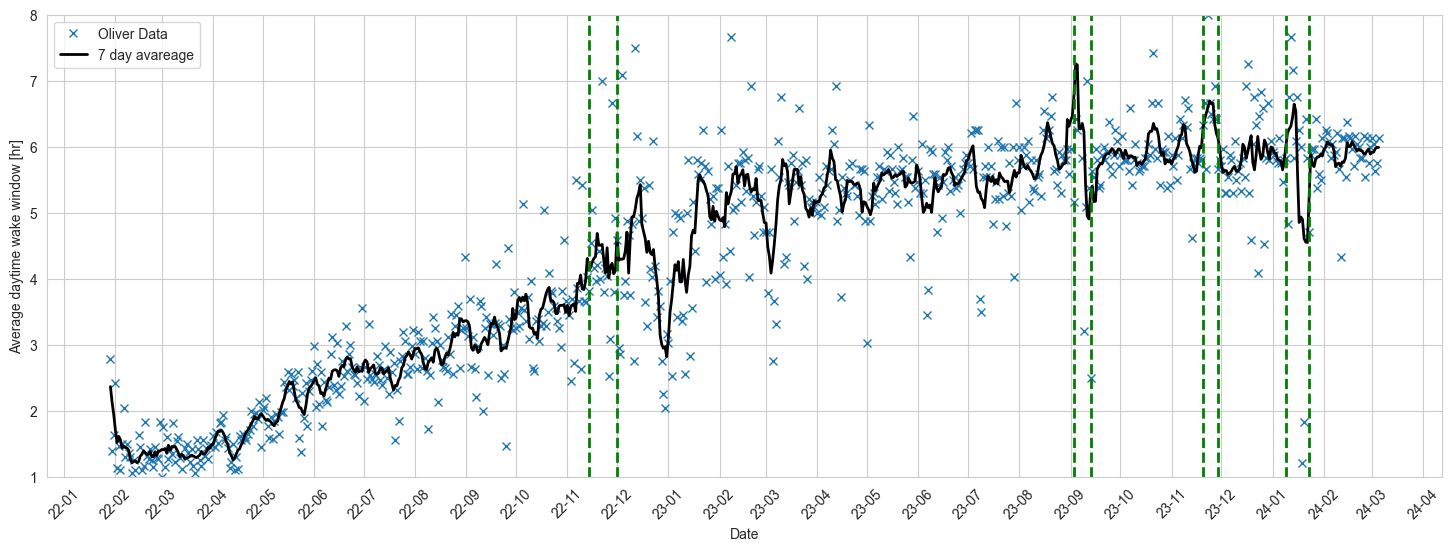

In [270]:
# Plot Average Wake Window
fig, ax = plt.subplots(figsize=(18,6))

SleepDaily['average day wake filtered']=uniform_filter1d(SleepDaily['average day wake'], filter_window, mode='nearest') 

curve1, = ax.plot(SleepDaily['average day wake'],'x',markersize=6,label='Oliver Data')
curve2, = ax.plot(SleepDaily['average day wake filtered'],color='k',linewidth=2,label=filter_label)

#curve8c = ax[4].axhline(y=1.5, xmin = 0, xmax = index3mo/day[-1],color='r',label='Recommend max') #c="red",linewidth=1)
#curve8d = ax[4].axhline(y=2, xmin = index3mo/day[-1], xmax = day[-1],color='r') #c="red",linewidth=1)

ax.set(ylabel='Average daytime wake window [hr]',ylim=[1,8]);

ax.legend(loc='upper left')

for i in tzChange.index:
    ax.axvline(x = tzChange['datetime'][i].date(), color='g', linestyle='dashed',linewidth=2);

ax.set(xlabel='Date');
plt.xticks(rotation = 45);

ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))

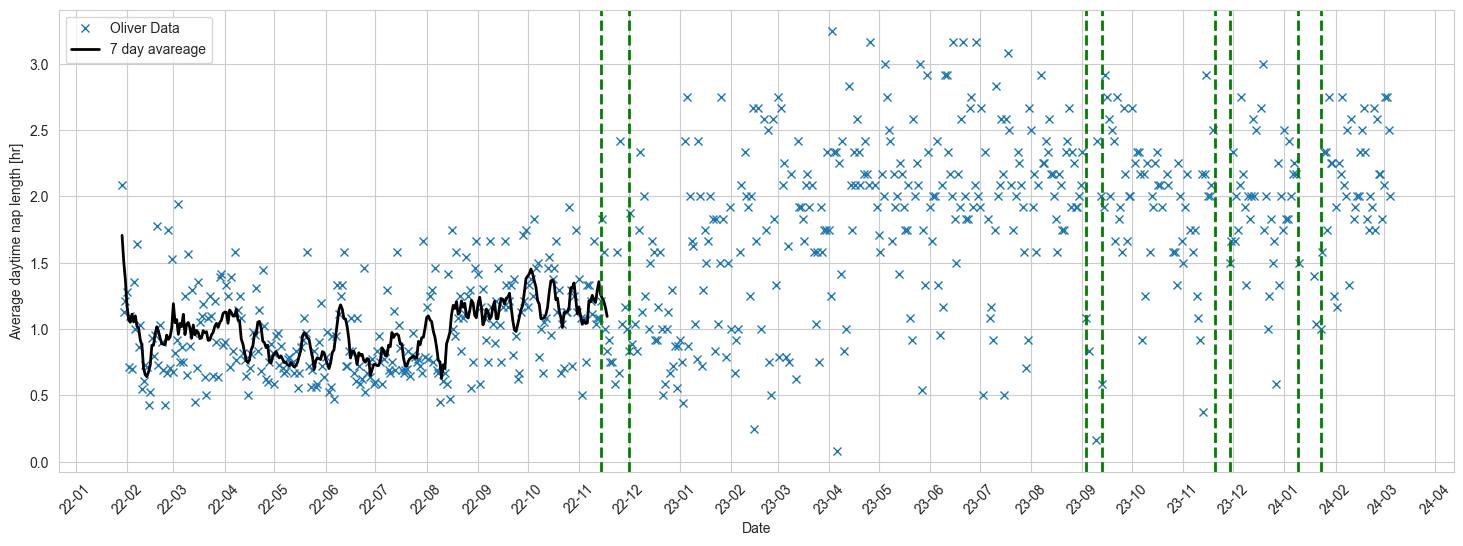

In [271]:
# Plot Average Wake Window
fig, ax = plt.subplots(figsize=(18,6))

SleepDaily['average day nap filtered']=uniform_filter1d(SleepDaily['average day nap'], filter_window, mode='nearest') 

curve1, = ax.plot(SleepDaily['average day nap'],'x',markersize=6,label='Oliver Data')
curve2, = ax.plot(SleepDaily['average day nap filtered'],color='k',linewidth=2,label=filter_label)

#curve8c = ax[5].axhline(y=2, xmin = 0, xmax = index3mo/day[-1],color='r',label='Recommend max') #c="red",linewidth=1)

ax.set(ylabel='Average daytime nap length [hr]');

ax.legend(loc='upper left')

for i in tzChange.index:
    ax.axvline(x = tzChange['datetime'][i].date(), color='g', linestyle='dashed',linewidth=2);

ax.set(xlabel='Date');
plt.xticks(rotation = 45);

ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))

Not sure what is happening here that the smoothing stops

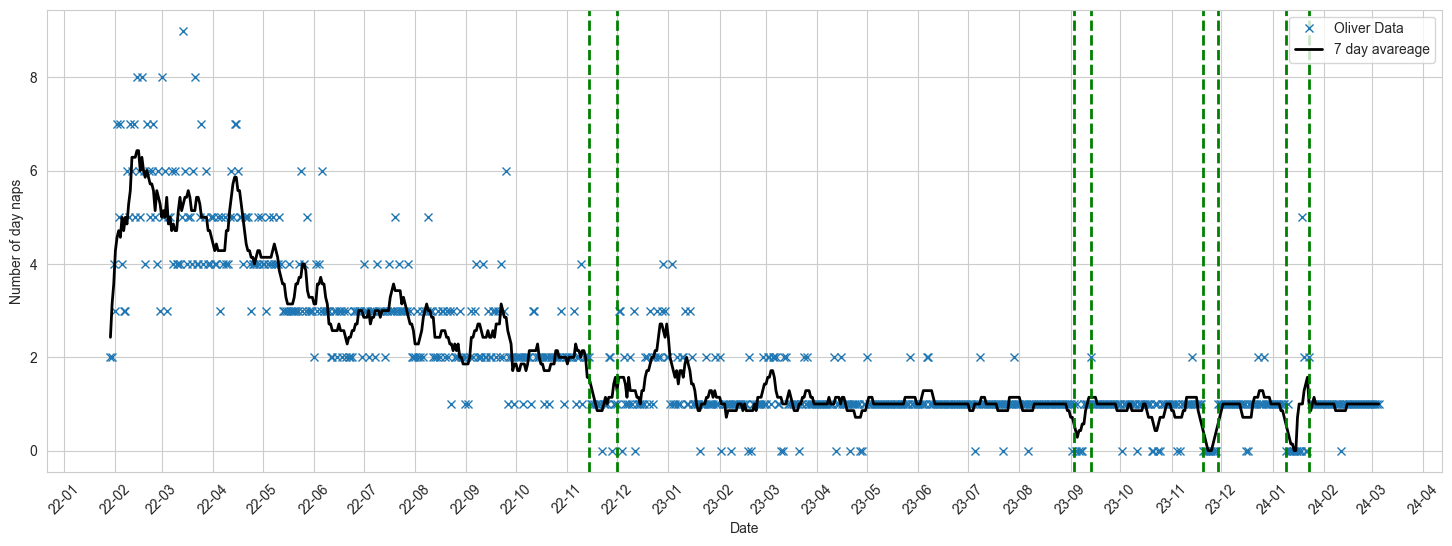

In [264]:
# Plot Number of day naps
fig, ax = plt.subplots(figsize=(18,6))
SleepDaily['day naps filtered']=uniform_filter1d(SleepDaily['day naps'].astype('float'), filter_window, mode='nearest') 

curve1, = ax.plot(SleepDaily['day naps'],'x',markersize=6,label='Oliver Data')
curve2, = ax.plot(SleepDaily['day naps filtered'],color='k',linewidth=2, label=filter_label)

ax.set(ylabel='Number of day naps');

ax.legend(loc='upper right')

for i in tzChange.index:
    ax.axvline(x = tzChange['datetime'][i].date(), color='g', linestyle='dashed',linewidth=2);

ax.set(xlabel='Date');
plt.xticks(rotation = 45);

ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))

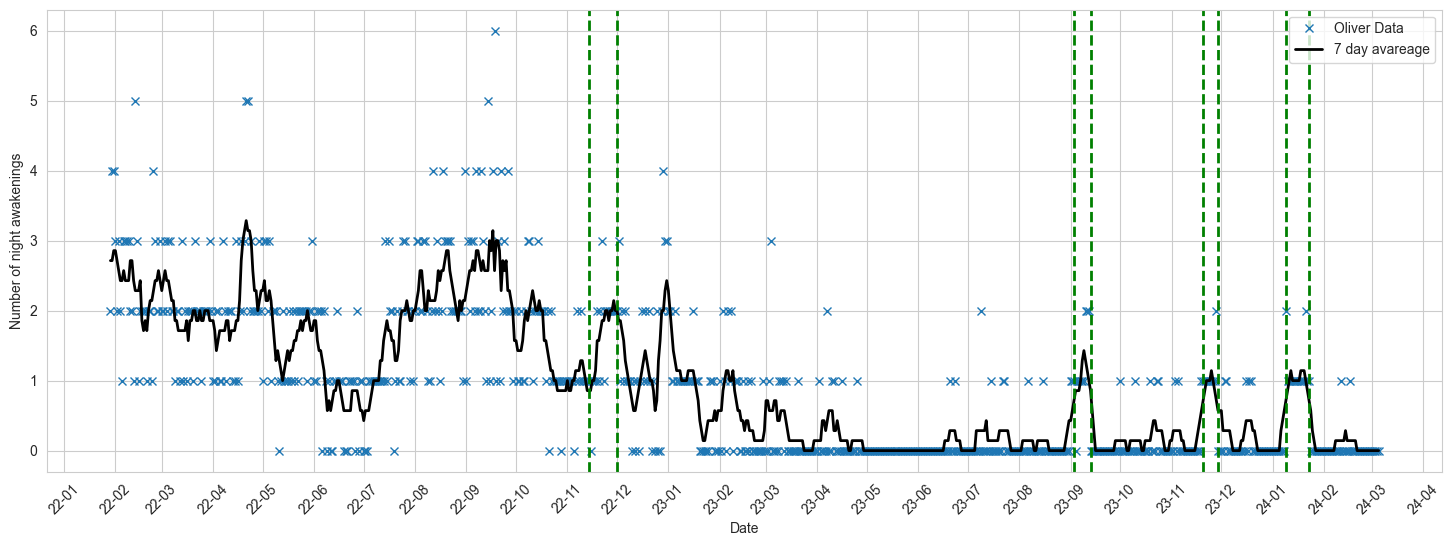

In [265]:
# Plot Number of night awakenings
fig, ax = plt.subplots(figsize=(18,6))

SleepDaily['night wakes filtered']=uniform_filter1d(SleepDaily['night wakes'].astype('float'), filter_window, mode='nearest') 

curve1, = ax.plot(SleepDaily['night wakes'],'x',markersize=6,label='Oliver Data');
curve2, = ax.plot(SleepDaily['night wakes filtered'],color='k',linewidth=2, label=filter_label)

ax.set(ylabel='Number of night awakenings');

ax.legend(loc='upper right')

for i in tzChange.index:
    ax.axvline(x = tzChange['datetime'][i].date(), color='g', linestyle='dashed',linewidth=2);

ax.set(xlabel='Date');
plt.xticks(rotation = 45);

ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))

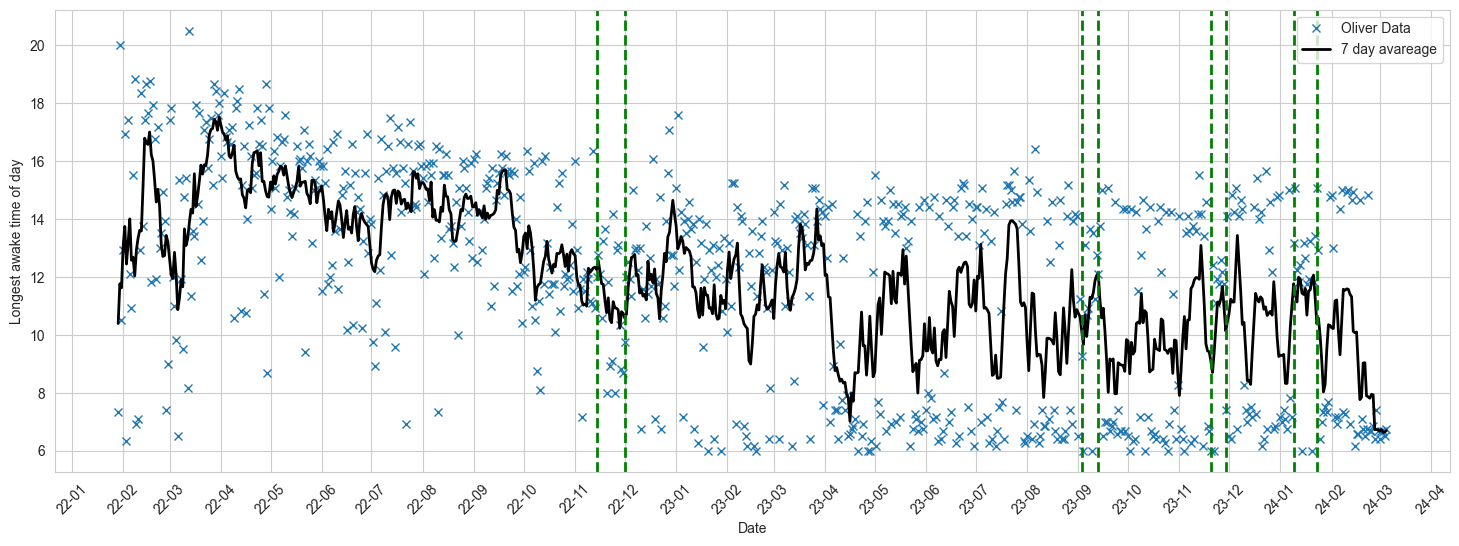

In [266]:
# Plot Longest awake time of day
fig, ax = plt.subplots(figsize=(18,6))

SleepDaily['longest wake hour filtered']=uniform_filter1d(SleepDaily['longest wake hour'], filter_window, mode='nearest') 

curve1, = ax.plot(SleepDaily['longest wake hour'],'x',markersize=6, label='Oliver Data')
curve2, = ax.plot(SleepDaily['longest wake hour filtered'],color='k',linewidth=2,label=filter_label)

ax.set(ylabel='Longest awake time of day');

ax.legend(loc='upper right')

for i in tzChange.index:
    ax.axvline(x = tzChange['datetime'][i].date(), color='g', linestyle='dashed',linewidth=2);

ax.set(xlabel='Date');
plt.xticks(rotation = 45);

ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))

The smoothing doesn't seem useful after the second year, there appears to be no trend of afternoon vs morning length

In [ ]:
Fig_name= 'Oliver_SleepTrends_'+ startDate.strftime("%m-%d-%y")+ '_to_' + endDate.strftime("%m-%d-%y");
fig.savefig(Fig_name)

## One-off daily sleep visualization (to inspect for anomalies)

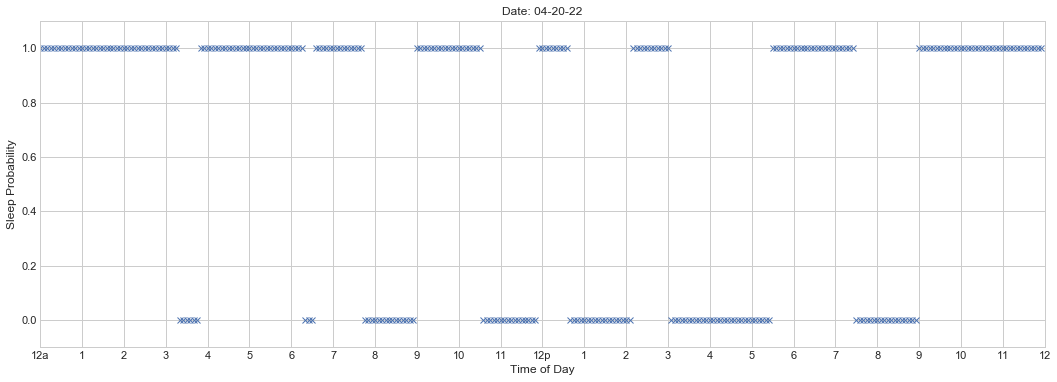

In [590]:
# This can used to visualize each individual vector by date (optional)

plt.figure(figsize=(18,6))
plt.style.use('seaborn-whitegrid')

plotDate=dt.date(2022,4,20)
dayNum=pd.Timedelta(plotDate-startDate).days

#plt.plot(dayvec)
plt.plot(dailySleepP[dayNum,],'x')
plt.xlabel('Time of Day')
plt.ylabel('Sleep Probability')

timeticks=np.arange(0, vectorIndexMax+1, step=int(vectorIndexMax/24));
timelabels=['12a','1','2','3','4','5','6','7','8','9','10','11','12p','1','2','3','4','5','6','7','8','9','10','11','12']
plt.xticks(timeticks,timelabels);  # Set label locations.
plt.axis([0, vectorIndexMax,-.1,1.1]);

#plotDate=startDate+pd.Timedelta(dayNum,'d')
plt.title('Date: '+ plotDate.strftime("%m-%d-%y"));